# Predictive Maintenance Use Case - Model Training

The goal of this notebook is to train a machine learning model that can predict the probability of failure in the future 20 cycles of a machine, based on a set of operational variables.

Data repository: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from pycaret.classification import  *
from sklearn.model_selection import train_test_split


# ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# define data sources
DATASOURCE = ('C:\\Users\\Samsung\\OneDrive\\Ícaro Augusto\\' +
              'Portfolio\\predictive_maintenance_case\\data\\1_raw')
DATA_SET = 'PM_train.txt'

In [3]:
# load the data
data = pd.read_csv(os.path.join(DATASOURCE, DATA_SET), header=None, sep=' ')

In [4]:
# visualize the data
data.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  

[5 rows x 28 columns]

- there are two additional columns with NaNs values

In [5]:
# drop null columns
null_cols = [26, 27]
data.drop(null_cols, axis=1, inplace=True)

In [6]:
# create real column names (based on the data dictionary)
real_cols = ['id', 'cycles', 'set1', 'set2', 'set3']
real_cols += [ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]

data.columns = real_cols

In [7]:
# check missing data
print(data.isna().sum().sum())

0


- no missing data

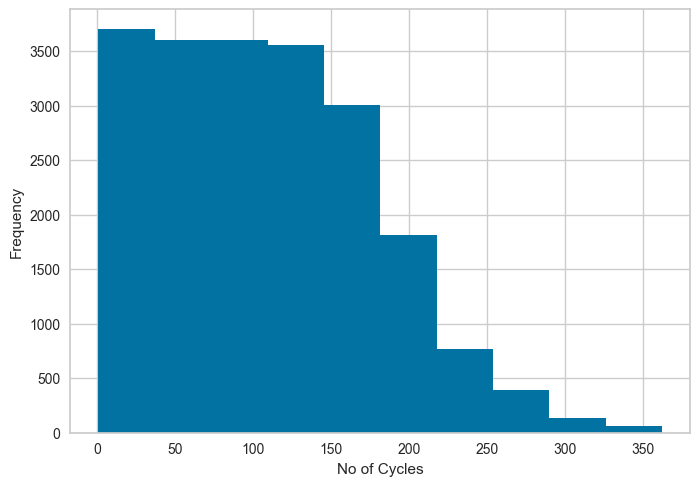

In [8]:
# lets check the distribution of cycles
plt.hist(data['cycles'])
plt.xlabel('No of Cycles')
plt.ylabel('Frequency')
plt.show()

- very skewed. Some machines are more durable than others. Maybe there is a minimum life time for all machines

In [9]:
# checking minimum lifetime of machines - is the maximum number of cycles that 100 % of the machines outlived

# calculate the maximum lifetime
max_life = data.groupby(by=['id'])['cycles'].max()

In [10]:
# evaluate how many machines outlive each number of cycles
min_n = max_life.min()
max_n = max_life.max()

survived= []
for n in range(min_n, max_n + 1):
    survived.append(max_life[max_life > n].shape[0] / max_life.shape[0])

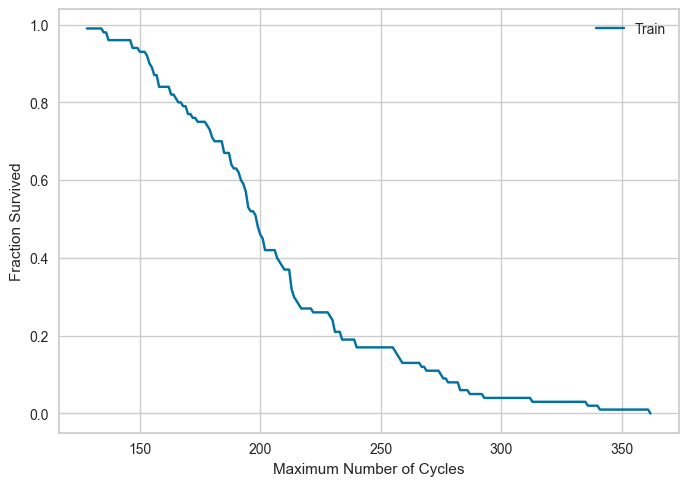

In [11]:
# plot the results
n_range = range(min_n, max_n + 1)

plt.plot(n_range, survived, label='Train')
plt.xlabel('Maximum Number of Cycles')
plt.ylabel('Fraction Survived')
plt.legend()
plt.show()

In [12]:
# find last value where 100 % of train machines survived
try:
    last_cycles = n_range[np.where(np.array(survived) == 1)[0][-1]]
except:
    last_cycles = 150

print('All machines in training set lasted up to {} cycles'.format(last_cycles))

All machines in training set lasted up to 150 cycles


- before 127 cycles, it makes no sense in modeling probability of failure. Let's remove those rows from both datasets.
- only the data from train will be removed

In [13]:
# removing rows with cycles below 127 cycles
# last_cycles = 150
data_train = data.loc[data['cycles'] >= last_cycles, :]

In [14]:
# now lets create the binary variable to label if the machine failed
def label_machine_failure(row: pd.Series, max_cycles_per_id: pd.Series) -> int:
    """
    create the failure class
    1 - the asset will fail in runtime + 30 cycles
    0 - the asset will not fail in runtime + 30 cycles

    Parameters
    ----------
    row : pd.Series
        dataframe row
    max_cycles_per_id : pd.Series
        maximum cycles per id dataset

    Returns
    -------
    int
        failure class
    """
    # business requirement
    CYCLE_THRESHOLD = 30

    # get the maximum cycle for that id
    max_cycle = max_cycles_per_id[row['id']]

    # if the present cycle + threshold surpass the history max, then the
    # asset failed
    if row['cycles'] + CYCLE_THRESHOLD > max_cycle:
        return 1
    
    return 0

In [15]:
# label both datasets
target = 'failure(t+30)'
data[target] = data.apply(label_machine_failure,
                                               max_cycles_per_id=max_life,
                                               axis=1)

In [16]:
# split train and test
data_train, data_test = train_test_split(data, test_size=0.3, random_state=42, stratify=data[target])

In [17]:
# check data balance
print('Original')
print(data[target].value_counts(normalize=True))

print('Train')
print(data_train[target].value_counts(normalize=True))

print('Test')
print(data_test[target].value_counts(normalize=True))

Original
failure(t+30)
0    0.854588
1    0.145412
Name: proportion, dtype: float64
Train
failure(t+30)
0    0.854581
1    0.145419
Name: proportion, dtype: float64
Test
failure(t+30)
0    0.854604
1    0.145396
Name: proportion, dtype: float64


- both datasets are very imbalanced. However, resampling is not a good technique because it bias the data distribution.
- in this example, we'll not be so rigorous and just train a classification model

In [18]:
# drop unused columns
data_train.drop(columns=['id'], inplace=True)
data_test.drop(columns=['id'], inplace=True)

In [19]:
# for the sake of simplicity, let's select the 5 features more correlated with the
# classes of failure - this means selecting via an hypothesis test
h_tests = pd.DataFrame(columns=['tag', 'U', 'p'])

for tag in data_train.columns:
    if tag not in [target, 'cycles']:
        # split groups
        group0 = data_train.loc[data_train[target]==0, tag].values
        group1 = data_train.loc[data_train[target]==1, tag].values

        # calculate non-parametric mann-whitney's u
        U, p = mannwhitneyu(group0, group1)

        # append to the dataframe
        h_tests.loc[h_tests.shape[0], ['tag', 'U', 'p']] = tag, U, p

In [20]:
# sort by statistic U
h_tests.sort_values(by=['p'], ascending=True, inplace=True)
h_tests

tag           U         p
23    (Low-pressure turbines Cool air flow)  24488962.5       0.0
19                         (Bleed Enthalpy)   1925562.5       0.0
17                          (Bypass Ratio)    1387425.5       0.0
15              (Corrected fan speed) (rpm)   2846007.5       0.0
4             (LPC outlet temperature) (◦R)   1807564.0       0.0
5             (HPC outlet temperature) (◦R)   2172832.5       0.0
6             (LPT outlet temperature) (◦R)   1002150.5       0.0
14  (Ratio of fuel flow to Ps30) (pps/psia)  24793763.5       0.0
13      (HPC outlet Static pressure) (psia)    773487.0       0.0
9              (HPC outlet pressure) (psia)  24691028.5       0.0
10               (Physical fan speed) (rpm)   2789095.5       0.0
22   (High-pressure turbines Cool air flow)  24347580.5       0.0
11              (Physical core speed) (rpm)   8854347.0       0.0
16             (Corrected core speed) (rpm)  10584511.0       0.0
8             (bypass-duct pressure) (psia)  12653550.0       0.0
0                                      set1  12745474.5  0.228675
1                                      set2  12775385.0  0.298786
7               (Fan inlet Pressure) (psia)  12958050.0       1.0
3              (Fan inlet temperature) (◦R)  12958050.0       1.0
2                                      set3  12958050.0       1.0
18                  (Burner fuel-air ratio)  12958050.0       1.0
20                     (Required fan speed)  12958050.0       1.0
21          (Required fan conversion speed)  12958050.0       1.0
12           (Engine pressure ratio(P50/P2)  12958050.0       1.0

In [21]:
# select top N most different
N = 10
cols_to_select = list(h_tests.head(N)['tag'].values)

# append cycles column and the target
cols_to_select += ['cycles', target]

In [22]:
# select columns
data_train = data_train[cols_to_select]
data_test = data_test[cols_to_select]

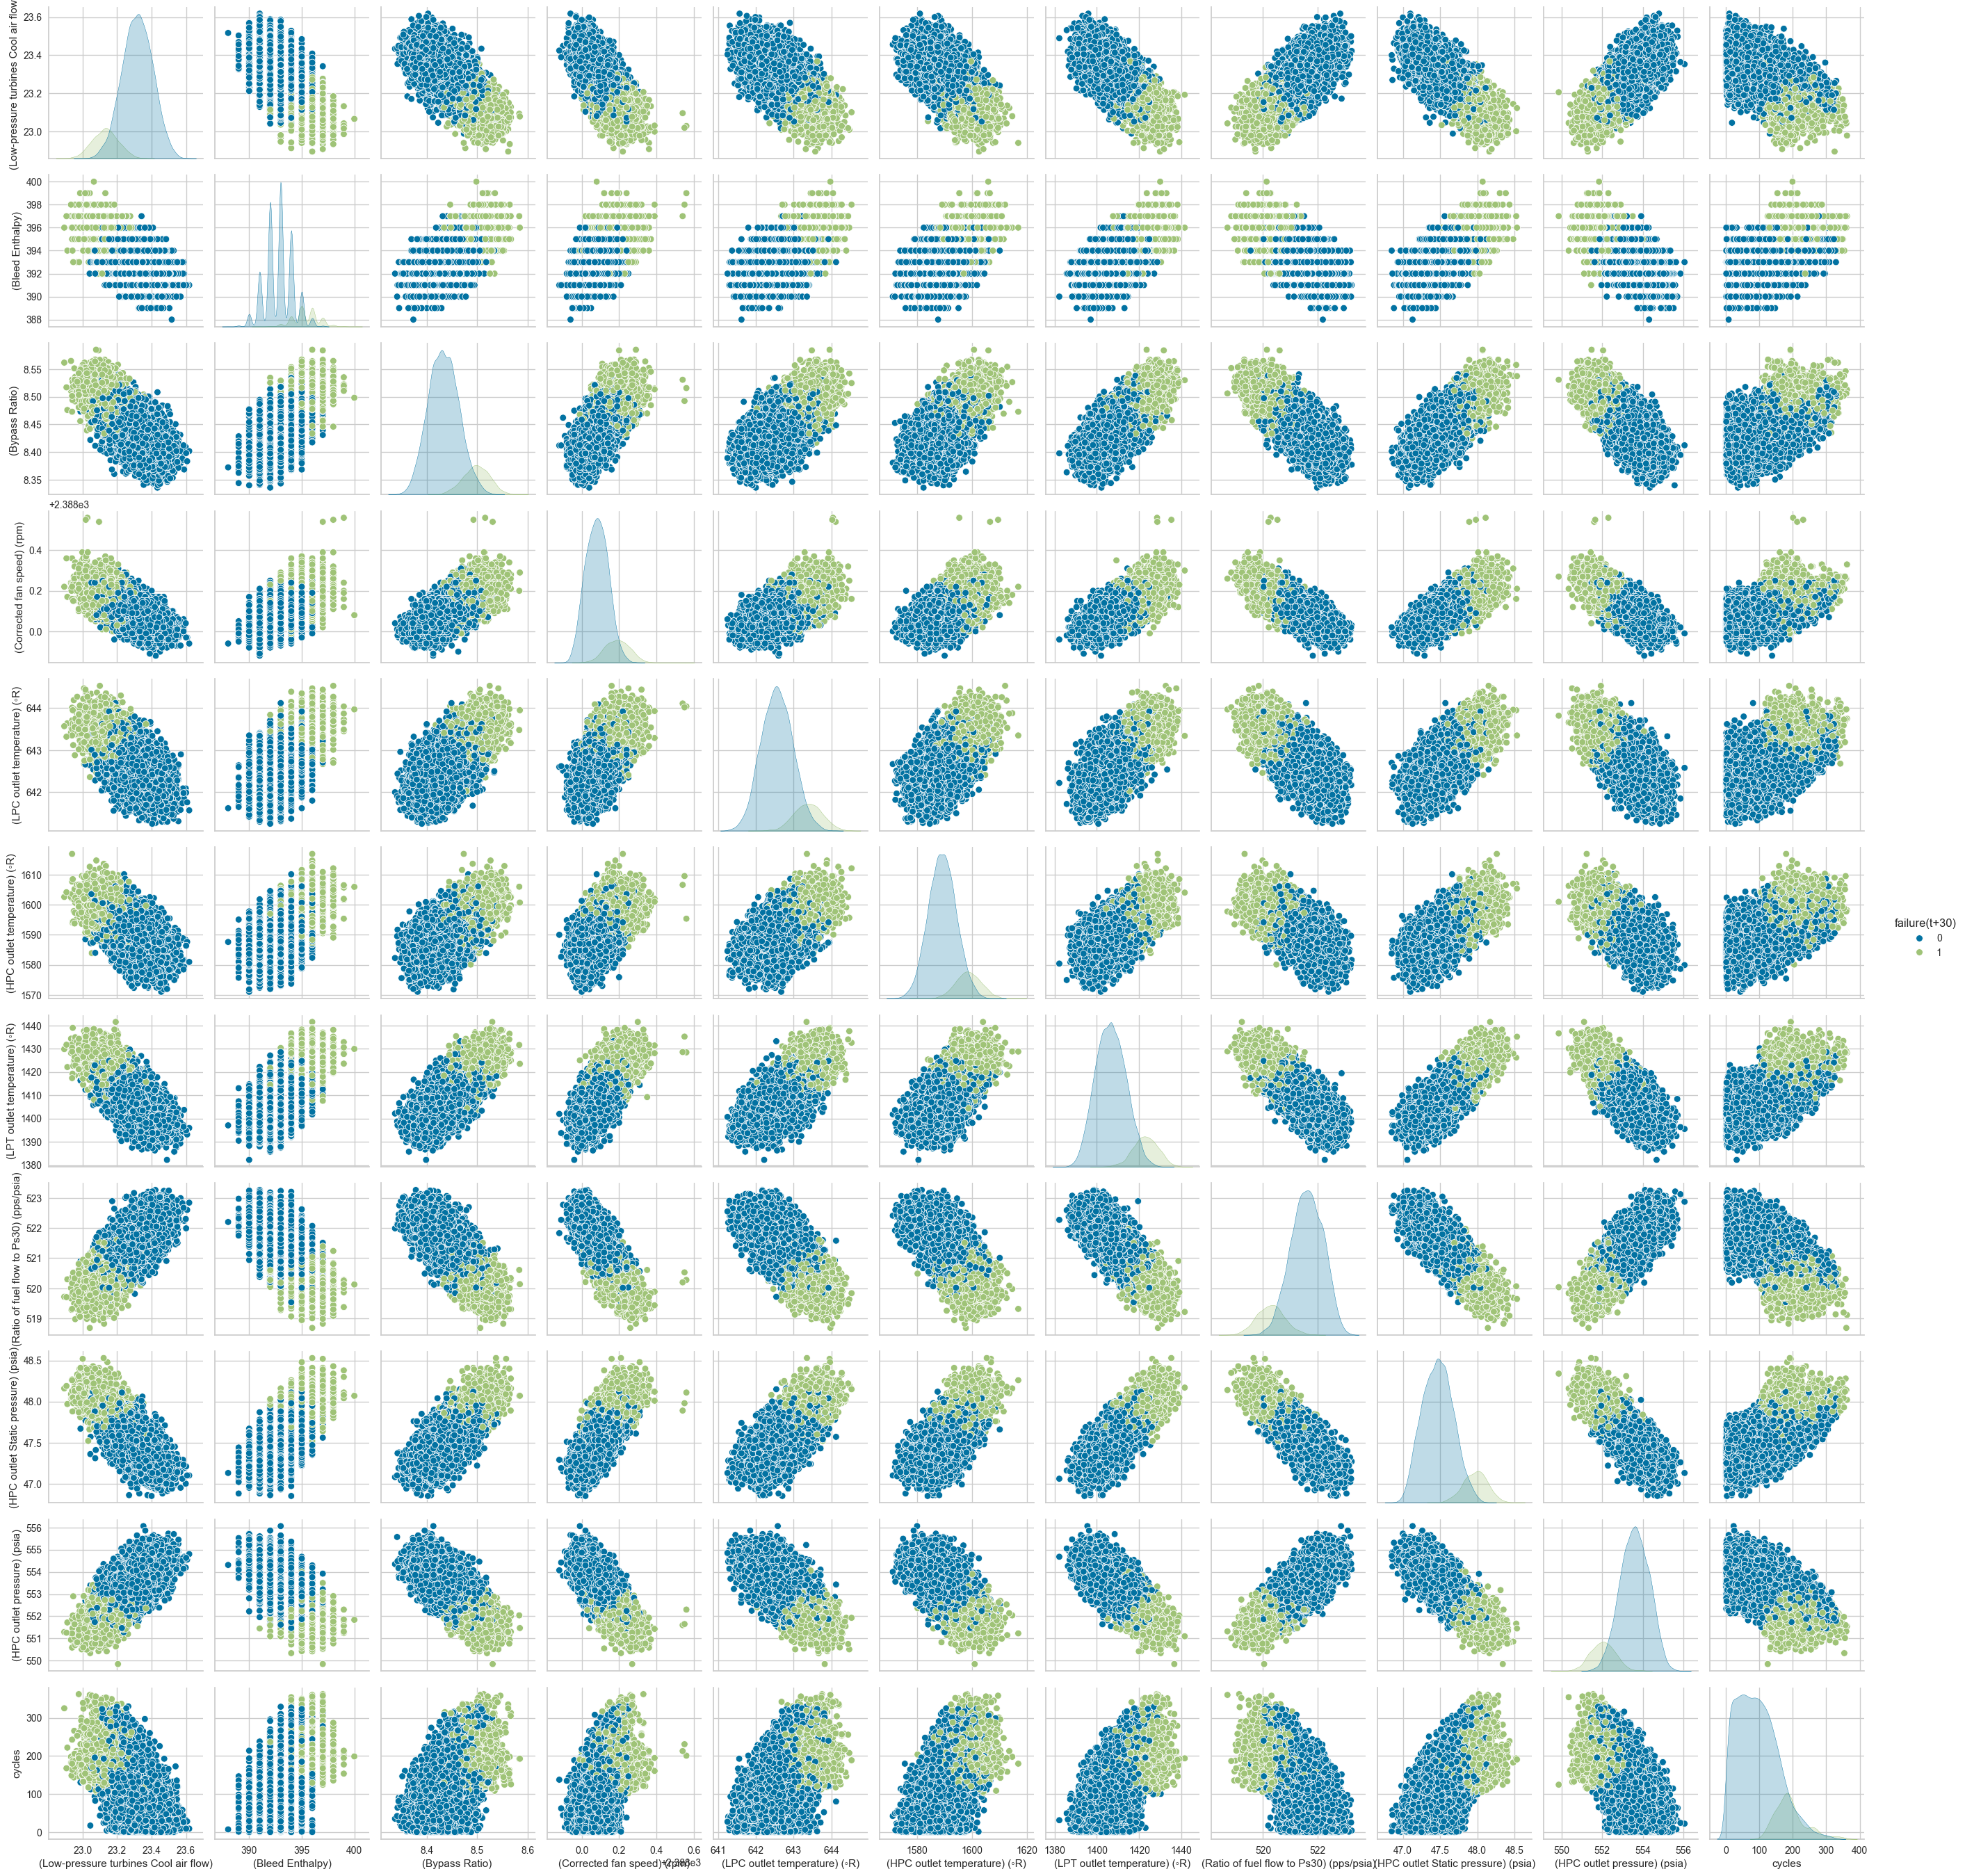

In [23]:
# analyze distribution of tags between classes
sns.pairplot(data_train, hue=target)

In [24]:
# checking the columns used for training
data_train.head()

(Low-pressure turbines Cool air flow)  (Bleed Enthalpy)  \
14777                                23.3187               393   
10157                                23.2153               392   
3909                                 23.0666               393   
20302                                23.4333               391   
12724                                23.2034               395   

       (Bypass Ratio)   (Corrected fan speed) (rpm)  \
14777           8.4135                      2388.09   
10157           8.4144                      2388.12   
3909            8.4955                      2388.22   
20302           8.4146                      2388.08   
12724           8.4680                      2388.17   

       (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  \
14777                         642.24                        1588.65   
10157                         642.75                        1588.34   
3909                          643.46                        1600.85   
20302                         642.07                        1587.02   
12724                         643.04                        1596.91   

       (LPT outlet temperature) (◦R)  (Ratio of fuel flow to Ps30) (pps/psia)  \
14777                        1398.17                                   522.36   
10157                        1404.10                                   521.17   
3909                         1413.51                                   519.70   
20302                        1401.42                                   522.29   
12724                        1417.07                                   521.33   

       (HPC outlet Static pressure) (psia)  (HPC outlet pressure) (psia)  \
14777                                47.44                        553.93   
10157                                47.52                        554.01   
3909                                 47.85                        551.68   
20302                                47.30                        553.59   
12724                                47.96                        552.54   

       cycles  failure(t+30)  
14777      14              0  
10157      36              0  
3909      134              1  
20302      57              0  
12724     244              0

In [25]:
# check variances
data_train.var()

(Low-pressure turbines Cool air flow)         0.011693
(Bleed Enthalpy)                              2.426729
(Bypass Ratio)                                0.001411
(Corrected fan speed) (rpm)                   0.005215
(LPC outlet temperature) (◦R)                 0.252607
(HPC outlet temperature) (◦R)                37.100071
(LPT outlet temperature) (◦R)                80.960630
(Ratio of fuel flow to Ps30) (pps/psia)       0.545863
(HPC outlet Static pressure) (psia)           0.071790
(HPC outlet pressure) (psia)                  0.781612
cycles                                     4744.861974
failure(t+30)                                 0.124281
dtype: float64

In [26]:
# pre-select the models
session_0 = setup(data_train,
                  target=target,
                  session_id=123,
                  low_variance_threshold=1e-4,
                  remove_multicollinearity=True,
                  feature_selection=True,
                  n_features_to_select=5,
                  use_gpu=True,
                  experiment_name='baseline')

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

In [27]:
# compare the baseline models
TOP_MODELS = 5
best_baseline_model = compare_models(sort='MCC', n_select=TOP_MODELS)

- considering that, in this business scenario, a False positive is as unwanted as a false negative
    - a false positive means we're doing unnecessary maintenance in the asset, and maoney is spent in personel, spare parts, and unavailability of assets
    - a false negative means we are not doing the necessary maintenance, and the asset will become unnavailable in the next 20 cycles, causing losses of productions and decrease of efficiency
- in this case, we're going to use the Matthews Correlation Coefficient (MCC) because it takes into account all the four entries of our confusion matrix. The MCC is high only if the classifier is doing well in both the negative and positive classes.
- in this case, the best baseline model is the Extra Trees Classifier
- However, let's tune the first 5 models to check if we got better results than the baseline.

In [28]:
# evaluate the models in the test set
test_results = {}
for model in best_baseline_model:
    test_results[model] = predict_model(model, data=data_test)

In [29]:
tune_results = {}
for model in best_baseline_model:

    print('Tuning Model {}'.format(model))

    # create model
    model_obj = create_model(model)

    # tune model
    tune_results[model] = tune_model(model_obj, optimize='MCC', n_iter=20)

Tuning Model QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tuning Model GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tuning Model LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                           priors=None, shrinkage=None, solver='svd',
                           store_covariance=False, tol=0.0001)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tuning Model ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Tuning Model AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
# try to use a blend of the three best models
three_best = [tune_results[model] for model in best_baseline_model]

# blend models - voting classifier
vote_model = blend_models(three_best, optimize='MCC')

In [31]:
# stack models
stack_model = stack_models(three_best, optimize='MCC')

Initiated  . . . . . . . . . . . . . . . . . .              00:48:12
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

In [32]:
test_results['voting'] = predict_model(vote_model, data=data_test)
test_results['stack'] = predict_model(stack_model, data=data_test)

- voting classifier improved the model results

In [36]:
tune_results

{QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                               store_covariance=False, tol=0.0001): QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                               store_covariance=False, tol=0.0001),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
                            random_state=123, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False): GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning

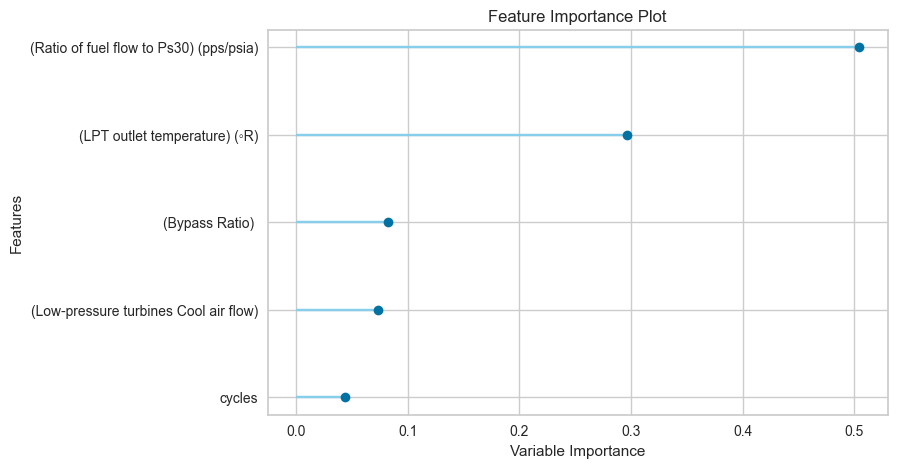

In [38]:
# check features importances
plot_model(tune_results[list(tune_results.keys())[1]], plot='feature')

In [40]:
# check variables inputed
get_config('X_train').describe()

(Low-pressure turbines Cool air flow)  (Bleed Enthalpy)  \
count                           10108.000000      10108.000000   
mean                               23.290228        393.198061   
std                                 0.108246          1.566743   
min                                22.907101        388.000000   
25%                                23.222700        392.000000   
50%                                23.299000        393.000000   
75%                                23.367201        394.000000   
max                                23.618401        399.000000   

       (Bypass Ratio)   (Corrected fan speed) (rpm)  \
count     10108.000000                 10108.000000   
mean          8.441928                  2388.096191   
std           0.037485                     0.072913   
min           8.335800                  2387.879883   
25%           8.414800                  2388.040039   
50%           8.438600                  2388.090088   
75%           8.465100                  2388.139893   
max           8.584800                  2388.560059   

       (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  \
count                   10108.000000                   10108.000000   
mean                      642.682373                    1590.491821   
std                         0.502540                       6.056146   
min                       641.250000                    1571.040039   
25%                       642.320007                    1586.270020   
50%                       642.650024                    1590.099976   
75%                       643.000000                    1594.362488   
max                       644.530029                    1616.910034   

       (LPT outlet temperature) (◦R)  (Ratio of fuel flow to Ps30) (pps/psia)  \
count                   10108.000000                             10108.000000   
mean                     1408.897949                               521.415710   
std                         8.987593                                 0.738585   
min                      1382.250000                               518.690002   
25%                      1402.359985                               520.960022   
50%                      1407.854980                               521.489990   
75%                      1414.550049                               521.950012   
max                      1438.959961                               523.239990   

       (HPC outlet Static pressure) (psia)  (HPC outlet pressure) (psia)  \
count                         10108.000000                  10108.000000   
mean                             47.540783                    553.367004   
std                               0.268467                      0.886998   
min                              46.849998                    550.340027   
25%                              47.349998                    552.809998   
50%                              47.509998                    553.440002   
75%                              47.700001                    554.010010   
max                              48.480000                    556.059998   

             cycles  
count  10108.000000  
mean     108.366838  
std       69.349257  
min        1.000000  
25%       51.000000  
50%      102.000000  
75%      156.000000  
max      362.000000

In [41]:
calibrate_model(vote_model)

CalibratedClassifierCV(cv=5, ensemble=True,
                       estimator=VotingClassifier(estimators=[('Quadratic '
                                                               'Discriminant '
                                                               'Analysis',
                                                               QuadraticDiscriminantAnalysis(priors=None,
                                                                                             reg_param=0.0,
                                                                                             store_covariance=False,
                                                                                             tol=0.0001)),
                                                              ('Gradient '
                                                               'Boosting '
                                                               'Classifier',
                                                               GradientBoostingClassifier(ccp_alpha=0.0,
                                                                                          criterion='friedman_mse',
                                                                                          init=None,
                                                                                          learning_rate=0.1,
                                                                                          loss='log_lo...
                                                                                    min_weight_fraction_leaf=0.0,
                                                                                    monotonic_cst=None,
                                                                                    n_estimators=220,
                                                                                    n_jobs=-1,
                                                                                    oob_score=False,
                                                                                    random_state=123,
                                                                                    verbose=0,
                                                                                    warm_start=False)),
                                                              ('Ada Boost '
                                                               'Classifier',
                                                               AdaBoostClassifier(algorithm='SAMME.R',
                                                                                  estimator=None,
                                                                                  learning_rate=1.0,
                                                                                  n_estimators=50,
                                                                                  random_state=123))],
                                                  flatten_transform=True,
                                                  n_jobs=1, verbose=False,
                                                  voting='soft', weights=None),
                       method='sigmoid', n_jobs=None)

In [42]:
# save model
save_model(vote_model, './model/vote_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['(Low-pressure turbines Cool air '
                                              'flow)',
                                              '(Bleed Enthalpy)',
                                              '(Bypass Ratio) ',
                                              '(Corrected fan speed) (rpm)',
                                              '(LPC outlet temperature) (◦R)',
                                              '(HPC outlet temperature) (◦R)',
                                              '(LPT outlet temperature) (◦R)',
                                              '(Ratio of fuel flow to Ps30) '
                                              '(pps/psia)',
                                              '(HPC outlet Static pr...
                                                                     min_weight